In [1]:
# --- NO TYPE 3 FONTS IN PDF OUTPUT ---
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["mathtext.fontset"] = "dejavusans"
mpl.rcParams["text.usetex"] = False

# Font sizes
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 12
# -------------------------------------

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon as MplPolygon

from time import time

import numpy as np
np.random.seed(1234)

import tensorflow as tf
tf.random.set_seed(1234)

import gpflow
gpflow.config.set_default_float(np.float32)
gpflow.config.set_default_jitter(1e-2)

from sgptools.methods import *
from sgptools.kernels import get_kernel
from sgptools.utils.tsp import *
from sgptools.utils.misc import *
from sgptools.utils.metrics import *
from sgptools.utils.data import Dataset
from sgptools.utils.gpflow import get_model_params

2026-01-09 14:43:45.759367: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 14:43:45.759808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 14:43:45.761559: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 14:43:45.766453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767991425.775238  609275 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767991425.77

In [2]:
def get_grid(X_data, num_x, num_y):
    grid_x, grid_y = np.mgrid[min(X_data[:, 0]):max(X_data[:, 0]):complex(num_x), 
                              min(X_data[:, 1]):max(X_data[:, 1]):complex(num_y)]
    X_grid = np.stack([grid_x, grid_y], axis=-1)
    return X_grid.reshape(-1, 2).astype(X_data.dtype)

In [3]:
# Load data
num_initial = 350
data = np.load("N47W124.npy")

# Get dataset
dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000)
del data
X_train, y_train = dataset.get_train()

# Generate X_init
X_init = get_inducing_pts(X_train, num_inducing=15)
X_init, _ = run_tsp(X_init)
X_init = X_init[0]
X_init = resample_path(X_init, num_initial)
X_init = X_init.astype(X_train.dtype)
X_init, y_init = dataset.get_sensor_data(X_init,
                                         max_samples=len(X_init))
print("Init Set Dims:", X_init.shape)

# Generate X_test
x_dim, y_dim = 100, 100
X_grid = get_grid(X_train, x_dim, y_dim)
X_grid, y_grid = dataset.get_sensor_data(X_grid,
                                         max_samples=len(X_grid))
print("Grid Set Dims:", X_grid.shape)

# Get the extent for potting
extent = [min(X_train[:, 0]), max(X_train[:, 0]), 
          min(X_train[:, 1]), max(X_train[:, 1])]

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (2500, 2), (2500, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.
Init Set Dims: (350, 2)
Grid Set Dims: (10000, 2)


W0000 00:00:1767991428.648147  609275 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


╒═════════════════════════════╤══════════════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤═══════════════════════════════════════════════════╕
│ name                        │ class            │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                             │
╞═════════════════════════════╪══════════════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪═══════════════════════════════════════════════════╡
│ SGPR.kernel._free_amplitude │ ResourceVariable │                  │         │ True        │ ()       │ float32 │ 1.11579                                           │
├─────────────────────────────┼──────────────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼───────────────────────────────────────────────────┤
│ SGPR.kernel.lengthscales    │ ResourceVariable │                  │         │ False       │ (10,)    │ float32 │ [1., 2., 3....                                    

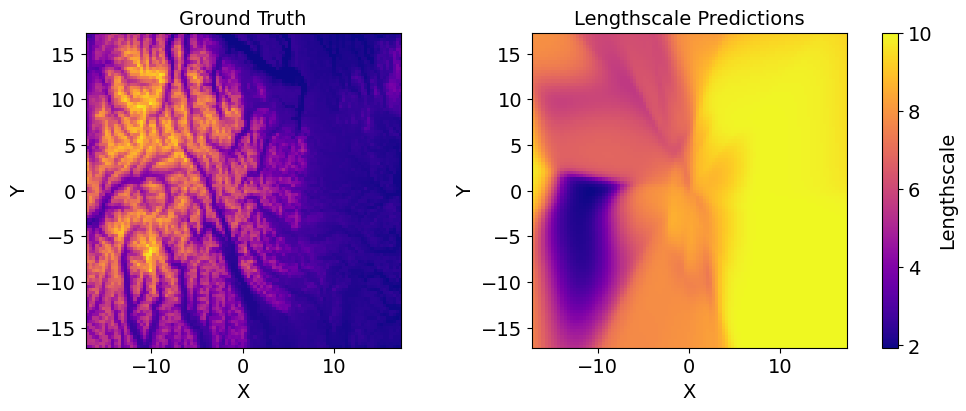

In [4]:
# Get lengthscales
_, noise_variance, kernel = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('Attentive')(np.linspace(1, 10, 10)),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    verbose=True)
ls_grid = kernel.get_lengthscales(X_grid)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(y_grid.reshape(x_dim, y_dim).T,
                     extent=extent, origin="lower",
                     cmap='plasma')
axes[0].set_title("Ground Truth")
axes[0].set_aspect('equal')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Second subplot — test data
sc2 = axes[1].imshow(ls_grid.reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower",
                     cmap='plasma')
axes[1].set_title("Lengthscale Predictions")
axes[1].set_aspect('equal')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

# Shared colorbar
fig.colorbar(sc2, ax=axes, orientation='vertical', 
             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()

In [5]:
var_threshold = 1.2
X_candidates = np.array(X_train)
X_objective = np.array(X_grid)

candidate_vars = kernel.K_diag(X_candidates).numpy()
objective_vars = kernel.K_diag(X_objective).numpy()
fact_1 = np.abs(objective_vars - var_threshold)
fact_2 = candidate_vars + noise_variance
var_condition = np.outer(fact_2, fact_1)
prior_covs = kernel(X_candidates, X_objective).numpy()
coverages = (np.square(prior_covs) > var_condition).astype(np.bool_)

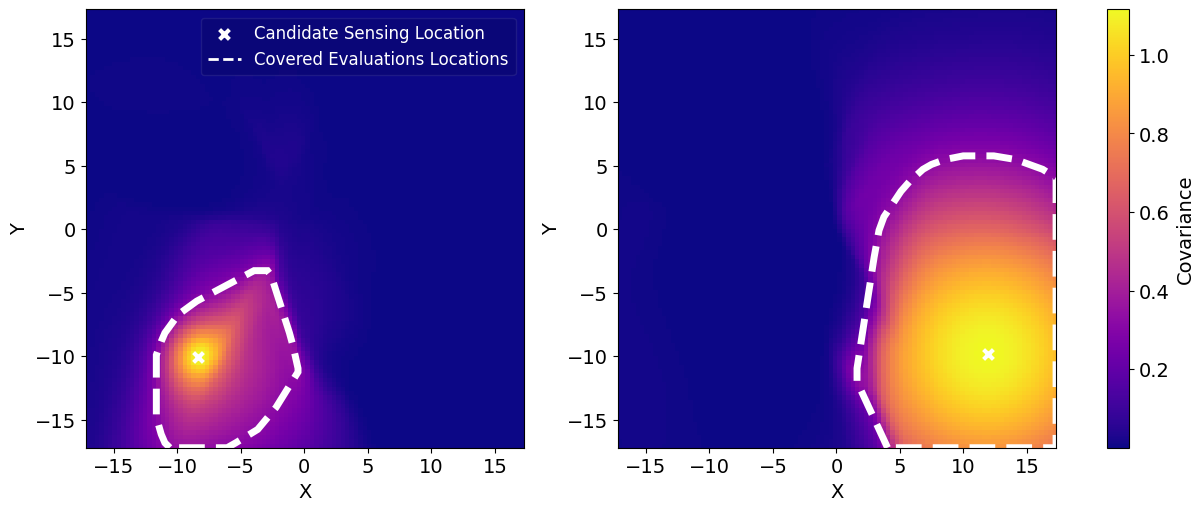

In [6]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon as MplPolygon

vmin = np.min(prior_covs)
vmax = np.max(prior_covs)

idxs = [3220, 4020]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

im = None
for j, (ax, idx) in enumerate(zip(axes, idxs)):
    # heatmap
    im = ax.imshow(
        prior_covs[idx, :].reshape(x_dim, y_dim).T,
        extent=extent,
        origin="lower",
        cmap="plasma",
        vmin=vmin,
        vmax=vmax
    )

    # candidate location
    ax.scatter(
        X_candidates[idx, 0], X_candidates[idx, 1],
        marker="x", c="w", s=50, linewidths=3, label="Candidate Sensing Location"
    )

    # FoV polygon
    coords = np.where(coverages[idx])
    coords = X_objective[coords]
    fov = geometry.Polygon(coords).convex_hull

    patch = MplPolygon(
        list(fov.exterior.coords),
        closed=True,
        facecolor="none",
        edgecolor="w",
        alpha=1.0,
        fill=False,
        linewidth=5,          # thick in plot
        linestyle="--",
        label="Covered Evaluations Locations"
    )
    ax.add_patch(patch)

    # legend with thin proxy line for polygon
    legend_poly = Line2D(
        [0], [0],
        color="w",
        linestyle="--",
        linewidth=2,          # thin in legend
        label="Covered Evaluations Locations"
    )

    handles, labels = ax.get_legend_handles_labels()
    new_handles = [legend_poly if (lbl == patch.get_label()) else h
                   for h, lbl in zip(handles, labels)]
    if j == 0:
        ax.legend(new_handles, labels, facecolor='k', framealpha=0.1, labelcolor='w')

    ax.set_aspect("equal")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

# single shared colorbar for both subplots
fig.colorbar(im, ax=axes, label="Covariance")

fig.savefig("FoVs.png", dpi=300, bbox_inches="tight")
plt.show()